## Big Data Derby 2022
Team: Joanna Kajka, Laura Hoang, Piotr Bielecki, Jakub Grunas

## Introduction & Summary

The notebook contains the analysis of horse tracking data. The idea of the project was to exctract several features from horses' coordinates after every 0.25 second in order to then fit a model to the data and finally generate feature importance in order to potentially identify patterns in strategies of winning horses.

The notebook contains only the code necessary to generate results (with some basic descriptions and conclusions), without multiple secondary analyses.
Apart from feature engineering and modelling, we decided to cluster together similar races - the algorithm turned out to be succesful and is described later in the notebook.

## Importing packages and data

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import datetime
import plotly.express as px
import statistics

In [86]:
nyra_start_table = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_start_table.csv', 
                               names=['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
nyra_race_table = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_race_table.csv')
nyra_tracking_table = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_tracking_table.csv')
df = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_2019_complete.csv',
                 names=['track_id', 'race_date', 'race_number', 'program_number', 'trakus_index', 'latitude', 'longitude', 'distance_id', 'course_type', 
                        'track_condition', 'run_up_distance', 'race_type', 'purse', 'post_time', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Preprocessing

### Column formatting: `race_date` and `program_number`

In [87]:
df['race_date'] = pd.to_datetime(df['race_date'], format='%Y-%m-%d')
nyra_tracking_table['race_date'] = pd.to_datetime(nyra_tracking_table['race_date'], format='%Y-%m-%d')

df['program_number'] = df['program_number'].map(lambda x : 91 if x == '1A ' else (92 if x == '1X ' else (93 if x == '2B ' else (94 if x == '3X ' else int(x)))))
nyra_tracking_table['program_number'] = nyra_tracking_table['program_number'].map(lambda x : 91 if x == '1A ' else (92 if x == '1X ' else (93 if x == '2B ' else (94 if x == '3X ' else int(x)))))
nyra_start_table['program_number'] = nyra_start_table['program_number'].map(lambda x : 91 if x == '1A ' else (92 if x == '1X ' else (93 if x == '2B ' else (94 if x == '3X ' else int(x)))))

### `Angle` column
Angle calculated between horse's second to last position, last position and current position.

In [88]:
df.sort_values(['race_date', 'track_id', 'race_number', 'course_type', 'program_number', 'trakus_index'], inplace=True)

df['prev_lat'] = df.groupby(['track_id', 'race_date', 'race_number', 'course_type', 'program_number'])['latitude'].shift(1)
df['prev_lon'] = df.groupby(['track_id', 'race_date', 'race_number', 'course_type', 'program_number'])['longitude'].shift(1)

df['prev_prev_lat'] = df.groupby(['track_id', 'race_date', 'race_number', 'course_type', 'program_number'])['latitude'].shift(2)
df['prev_prev_lon'] = df.groupby(['track_id', 'race_date', 'race_number', 'course_type', 'program_number'])['longitude'].shift(2)
df[['track_id', 'race_date', 'race_number', 'program_number', 'trakus_index', 'latitude', 'longitude', 'prev_lat', 'prev_lon', 'prev_prev_lat', 'prev_prev_lon']].head()

In [89]:
from cmath import pi

def unit_vector(v):
    """ Returns a unit vector of v. """
    return v / np.linalg.norm(v)

def angle(x1, y1, x2, y2, x3, y3):
    """ Returns an angle (in degrees) between points P1, P2 and P3, where Pi=(xi,yi). """
    v1 = (x2-x1, y2-y1)
    v2 = (x3-x2, y3-y2)
    
    u1 = unit_vector(v1)
    u2 = unit_vector(v2)
    rad = np.arccos(np.clip( np.dot(u1,u2), -1.0, 1.0 ))  # angle in radians
    return rad*180/pi

df['angle'] = df.apply(
    lambda df: angle(df['prev_prev_lon'], df['prev_prev_lat'], df['prev_lon'], df['prev_lat'], df['longitude'], df['latitude']), axis=1)
df['angle'] = df['angle'].fillna(0)

### Polar coordinates: `phi` column
Angle phi calculated between two vectors: horse's position - track's center and vector parallel to the equator that crosses the center of the track. This feature gives us position of a horse on a track regardless of race's starting line.

In [90]:
AQU = df[df.track_id=='AQU']
BEL = df[df.track_id=='BEL']
SAR = df[df.track_id=='SAR']
points_aqu = AQU[(AQU.race_date=='2019-11-09')&(AQU.race_number==8)][['latitude','longitude']]
points_bel = BEL[(BEL.race_date=='2019-09-19')&(BEL.race_number==1)][['latitude','longitude']]
points_sar = SAR[(SAR.race_date=='2019-07-27')&(SAR.race_number==5)][['latitude','longitude']]
pts_aqu = np.column_stack((points_aqu.latitude.to_list(), points_aqu.longitude.to_list()))
pts_bel = np.column_stack((points_bel.latitude.to_list(), points_bel.longitude.to_list()))
pts_sar = np.column_stack((points_sar.latitude.to_list(), points_sar.longitude.to_list()))

#### Finding track centers

In [91]:
from warnings import warn

from numpy import pi
from numpy import sqrt
from numpy import arccos
from numpy import dot, outer
from numpy import diag, transpose
from numpy import append
from numpy import asarray
from numpy import ones
from numpy import argmax

from numpy.linalg import inv
from numpy.linalg import norm
from numpy.linalg import eig


def mvee( data, tolerance=1e-4, maxcnt=1000 ):
    """
    param data: list of xy data points
    param tolerance: termination condition for iterative approximation
    param maxcnt: maximum number of iterations
    type data: iterable of float
    type tolerance: float
    return: (offset, semiaxis, angle)
    return type: ( (float, float), (float, float), float )
    """
    locdata = asarray( data )
    N = len( locdata )
    if not locdata.shape == ( N, 2):
        raise ValueError ( " data must be of shape( n, 2 )" )
    if tolerance >= 1 or tolerance <= 0:
        raise ValueError (" 0 < tolerance < 1 required")
    if not isinstance( maxcnt, int ):
        raise TypeError
    if not maxcnt > 0:
        raise ValueError
    count = 1
    err = 1
    d = 2
    d1 = d + 1
    u = ones( N ) / N
    P = transpose( locdata )
    Q = append( P, ones( N ) ).reshape( 3, -1 )
    while ( err > tolerance):
        X = dot( Q, dot( diag( u ), transpose( Q ) ) )
        M = diag( 
            dot( 
                transpose( Q ),
                dot(
                    inv( X ),
                    Q
                )
            )
        )
        maximum = max( M )
        j = argmax( M )
        step_size = ( maximum - d1 ) / ( d1 * ( maximum - 1 ) )
        new_u = ( 1 - step_size ) * u
        new_u[ j ] += step_size
        err = norm( new_u - u )
        count = count + 1
        u = new_u
        if count > maxcnt:
            warn(
                "Process did not converge in {} steps".format(
                    count - 1
                ),
                UserWarning
            )
            break
    c = dot( P,  u )
    return c

In [92]:
center_aqu = mvee(pts_aqu)
center_bel = mvee(pts_bel)
center_sar = mvee(pts_sar)

def lat(row):
    if row['track_id'] == 'AQU':
        val = row['latitude'] - center_aqu[0]
    elif row['track_id'] == 'BEL':
        val = row['latitude'] - center_bel[0]
    else:
        val = row['latitude'] - center_sar[0]
    return val
def long(row):
    if row['track_id'] == 'AQU':
        val = row['longitude'] - center_aqu[1]
    elif row['track_id'] == 'BEL':
        val = row['longitude'] - center_bel[1]
    else:
        val = row['longitude'] - center_sar[1]
    return val

df['long'] = df.apply(long, axis=1)
df['lat'] = df.apply(lat, axis=1)

df = df.assign(phi = lambda x: np.arctan2(x.lat, x.long))

df.drop(columns=['lat', 'long'], inplace=True)

### `Distance` and `speed` columns

In [93]:
import geopy.distance

def distance_covered(coords1, coords2):
    if math.isnan(coords1[0]): return 0
    return geopy.distance.geodesic((coords1), (coords2)).m
df['dst_covered'] = df.apply(lambda x: distance_covered((x['prev_lat'], x['prev_lon']), (x['latitude'], x['longitude'])), axis=1)

df['avg_speed'] = df['dst_covered'] / 0.25
df['max_race_speed'] = df.groupby(['track_id','race_date','race_number','course_type'])['avg_speed'].transform('max')
df['avg_rel_speed'] = df['avg_speed']/df['max_race_speed']

df['total_race_dist'] = df['run_up_distance']*0.3048 + df['distance_id']*2.01168
df['dst_covered_perc'] = df['dst_covered']/df['total_race_dist']
df['dst_covered_perc_cum'] = df.groupby(['track_id','race_date','race_number','course_type','program_number'])['dst_covered_perc'].cumsum()
df['dst_covered_bucket'] = pd.cut(df['dst_covered_perc_cum'],
                                  [-0.1,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,10],
                                  labels=range(20))

### `Pack_speed` column

In [94]:
tmp = pd.DataFrame({'pack_speed' : df.groupby( [ "track_id", "race_date", "race_number", "trakus_index"]).mean()["avg_speed"]}).reset_index()
df = df.merge(tmp, "left")
df["relative_speed"] = df["avg_speed"]-df["pack_speed"]
df.head(5)

This is how the resulting table looks like:

In [95]:
big_data_derby_2022_11_07 = pd.read_csv('../input/datasets-heads/big_data_derby_2022_11_07_head.csv', index_col=0)
big_data_derby_2022_11_07

track_id   race_date  race_number  program_number  trakus_index   latitude  \
0      AQU  2019-01-01            1               3             1  40.669396   
1      AQU  2019-01-01            1               3             2  40.669400   
2      AQU  2019-01-01            1               3             3  40.669405   
3      AQU  2019-01-01            1               3             4  40.669411   
4      AQU  2019-01-01            1               3             5  40.669423   

   longitude  distance_id course_type track_condition  ...  start_lat  \
0 -73.829169          650           D             MY   ...  40.669403   
1 -73.829167          650           D             MY   ...  40.669403   
2 -73.829163          650           D             MY   ...  40.669403   
3 -73.829160          650           D             MY   ...  40.669403   
4 -73.829154          650           D             MY   ...  40.669403   

   start_lon      phi2  phi2_diff  max_race_speed avg_rel_speed  \
0 -73.829172  0.029775        NaN       23.164309      0.000000   
1 -73.829172  0.094839   0.065065       23.164309      0.084169   
2 -73.829172  0.172408   0.077569       23.164309      0.108497   
3 -73.829172  0.259909   0.087500       23.164309      0.130066   
4 -73.829172  0.419023   0.159114       23.164309      0.254517   

   total_race_dist  dst_covered_perc  dst_covered_perc_cum  dst_covered_bucket  
0        1318.5648          0.000000              0.000000                   0  
1        1318.5648          0.000370              0.000370                   0  
2        1318.5648          0.000477              0.000846                   0  
3        1318.5648          0.000571              0.001417                   0  
4        1318.5648          0.001118              0.002535                   0  

[5 rows x 41 columns]

### `Section` column
`Section` column was calculated based on phi angle for each moment and grouped together observations from 6 parts of the track (beginning/middle/end of curve/straight).

### Removing ties in `position_at_finish`

In [96]:
tmp = df.groupby(["track_id", "race_date", "race_number", "position_at_finish"]).jockey.nunique().sort_values(ascending = False)
tmp = tmp.to_frame()
tmp = tmp[tmp["jockey"]>1]

for i in tmp.index:
    equal = df[(df["track_id"] == i[0]) &
            (df["race_date"] == i[1]) &
            (df["race_number"] == i[2]) &
            (df["position_at_finish"] == i[3])]
    jockeys = pd.unique(equal["jockey"])
    jockey = jockeys[0]
    df.loc[(df["track_id"] == i[0]) &
        (df["race_date"] == i[1]) &
        (df["race_number"] == i[2]) &
        (df["jockey"] == jockey), "position_at_finish"] = df.loc[(df["track_id"] == i[0]) &
                                                                (df["race_date"] == i[1]) &
                                                                (df["race_number"] == i[2]) &
                                                                (df["jockey"] == jockey), "position_at_finish"]+1

### Number of horses ahead: `horses_in_front` column

In [97]:
tmp = df.drop(columns = [i for i in df.columns if not i in ['track_id', 'race_date', 'race_number', 'jockey',
       'trakus_index', 'latitude', 'longitude', 'position_at_finish'] ] )
tmp2 = tmp.pivot(index = ["track_id", "race_date", "race_number","trakus_index"], columns = ["position_at_finish"], values = ["latitude","longitude"])
tmp2.columns = tmp2.columns.get_level_values(0) +"_" + [str(i) for i in tmp2.columns.get_level_values(1).to_list()]
tmp2
df = df.merge(tmp2, on = ["track_id", "race_date", "race_number", "trakus_index"])

from cmath import pi
def angle_to_horse(prev_x1, prev_y1, x1, y1, x2, y2):
    """returns angle in degrees to another horse"""
    vel = (x1-prev_x1, y1-prev_y1)
    radial = (x2-x1, y2-y1)
    vel = vel / np.linalg.norm(vel, axis = 0)
    radial = radial / np.linalg.norm(radial, axis = 0)
    rad = np.arccos(np.array(vel[0])*np.array(radial[0])+np.array(vel[1])*np.array(radial[1]))
    angle = rad*180/pi
    return angle

We calculate the number of horses ahead as the number of horses whose distance is lower than 5m, which have a position vector at an angle <10 degrees to the velocity vector of our horse. This calculation is then used to get an approximation for energy saved as a percentage of all energy otherwise spent by a horse in last 1/4 second.

In [98]:
horses_in_front = np.zeros((len(df.loc[:,["trakus_index"]]),1))
for i in range(1,14):
    distance = "distance_" + str(i)
    angle = "angle_"+str(i)
    distance = np.array(df.loc[:,[distance]])
    angle = np.array(df.loc[:,[angle]])
    distance = distance < 5
    angle = angle < 10
    horse_in_front = distance * angle
    horses_in_front = horses_in_front + horse_in_front

df["horses_in_front"] = np.int8(horses_in_front)

### Energy saving

According to: https://www.horsejournals.com/riding-training/english/other/slipstreaming-reduces-drag-horse-racing-66-percent#:~:text=Also%20known%20as%20drafting%2C%20slipstreaming,dash%20to%20the%20finish%20line.)

When two horses are in front of one horse, the drag of the trailing horse is reduced by 66 percent;
When two horses are running with one closely behind the other, the drag of the lead horse is reduced by 6.5 percent while the drag of the trailing horse is reduced by 38.5 percent.
In a situation where five horses are side by side, the drag of the centre horse actually increases by 25 percent.

According to: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3391435/

At 18 m s−1 (cf. figure 1a), this results in a drag force of 209 N,
requiring a mechanical power of 3.8 kW. The total mechanical
power of horse galloping has been estimated as 22.5 kW [10],
and therefore a rough estimate based on these figures is that overcoming drag
accounts for 17 per cent of total mechanical power.


In [99]:
def energy_saved(ahead):
    """return energy saved as % of all energy otherwise spent on the race"""
    draft_percent = 0.385*(ahead == 1) + 0.66*(ahead == 2) + 0.75*(ahead == 3) + 0.8*(ahead == 4)
    return(17/100 * draft_percent)

df["energy_saved"] = df.apply(lambda x: energy_saved(x.horses_in_front), axis = 1)

### Number of competitors: `competitors_in_race` column

In [100]:
tmp = nyra_start_table.groupby(["track_id", "race_date", "race_number"]).jockey.nunique()
tmp = tmp.to_frame()
tmp.rename(columns = {"jockey":"competitors_in_race"}, inplace = True)
df = df.merge(tmp, "inner", on=["track_id","race_date","race_number"])

### Calculating `position_in_race`

#### Number of competitors in the race

In [101]:
tmp = nyra_start_table.groupby(["track_id", "race_date", "race_number"]).jockey.nunique()
tmp = tmp.to_frame()
tmp.rename(columns = {"jockey":"competitors_in_race"}, inplace = True)
df = df.merge(tmp, "inner", on=["track_id","race_date","race_number"])

#### Number of horses behind

In [102]:
horses_behind = np.zeros((len(df2.loc[:,["trakus_index"]]),1))

for i in range(1,14):
    distance = "distance_" + str(i)
    angle = "angle_"+str(i)
    distance = np.array(df2.loc[:,[distance]])
    angle = np.array(df2.loc[:,[angle]])
    horse_behind = angle > 90
    horses_behind = horses_behind + horse_behind

df2["horses_behind"] = np.int8(horses_behind)

Finally, we get the `position_in_race` column.

In [103]:
df2["position_in_race"] = df2.competitors_in_race - df2.horses_behind

`avg_speed_to_pack_speed`

In [104]:
result['avg_speed_to_pack_speed'] = np.where(result.pack_speed==0, 0, result.avg_speed / result.pack_speed)

Right before pivoting, our dataframe looks like this:

In [105]:
final_preprocessing_head = pd.read_csv('../input/datasets-heads/final_preprocessing_head.csv', index_col=0)
final_preprocessing_head

track_id   race_date  race_number  program_number  trakus_index   latitude  \
0      AQU  2019-01-01            1               3             1  40.669396   
1      AQU  2019-01-01            1               3             2  40.669400   
2      AQU  2019-01-01            1               3             3  40.669405   
3      AQU  2019-01-01            1               3             4  40.669411   
4      AQU  2019-01-01            1               3             5  40.669423   

   longitude  distance_id course_type track_condition  ...  total_race_dist  \
0 -73.829169          650           D             MY   ...        1318.5648   
1 -73.829167          650           D             MY   ...        1318.5648   
2 -73.829163          650           D             MY   ...        1318.5648   
3 -73.829160          650           D             MY   ...        1318.5648   
4 -73.829154          650           D             MY   ...        1318.5648   

  dst_covered_perc  dst_covered_perc_cum  dst_covered_bucket  section  \
0         0.000000              0.000000                   0        3   
1         0.000370              0.000370                   0        3   
2         0.000477              0.000846                   0        3   
3         0.000571              0.001417                   0        3   
4         0.001118              0.002535                   0        3   

  position_in_race  energy_saved  competitors  horses_behind  \
0                5           0.0            5              0   
1                3           0.0            5              2   
2                3           0.0            5              2   
3                4           0.0            5              1   
4                2           0.0            5              3   

   avg_speed_to_pack_speed  
0                 0.000000  
1                 1.057698  
2                 0.996163  
3                 0.870173  
4                 1.163412  

[5 rows x 47 columns]

After caring out an additional analysis, we decided to change the range of `dst_covered_bucket` values.

In [106]:
data['dst_covered_bucket'] = data['dst_covered_bucket'].map({0:0,1:0,2:1,3:1,4:2,5:2,6:3,7:3,8:4,9:4,10:5,11:5,12:6,13:6,14:7,15:7,16:8,17:8,18:9,19:9})

### Aggregating the data
Aggregation algorithm was performed in order to get features for each decile for each horse for each race. After this process each row in the dataframe corresponds to a horse in a race and the columns represent generated earlier features for each decile of a race.

In [107]:
df = data.groupby(
                ['track_id', 'race_date', 'race_number', 'program_number', 'dst_covered_bucket'], as_index=False).aggregate({
                'distance_id' : 'max',
                'position_at_finish' : 'max',
                'avg_rel_speed': 'mean',
                'avg_speed_to_pack_speed' : 'mean',
                'section': ['mean', lambda x: str(list(x.unique())), 'min', 'max', 'nunique'], # 'section': 'mean',
                'position_in_race': 'mean',
                'angle': 'mean',
                'dst_covered_perc' : 'sum',
                'dst_covered_perc_cum' : 'max',
                'energy_saved' : 'mean'
                })

df.columns = ['track_id', 'race_date', 'race_number', 'program_number', 'dst_covered_bucket',
                'distance_id',
                'position_at_finish',
                'avg_rel_speed_mean',
                'avg_speed_to_pack_speed_mean',
                'section_mean', 'section_unique', 'section_min', 'section_max', 'section_nunique',
                'position_in_race_mean',
                'angle_mean',
                'dst_covered_perc_sum',
                'dst_covered_perc_cum_max',
                'energy_saved_mean']


In [108]:
df = df[df.dst_covered_bucket != 9]

In [109]:
df['section'] = np.where((df.section_nunique==1) | ((df.section_nunique==2) & ((df.section_min!=1) | (df.section_max!=6))) , df.section_mean, None)
df['section'] = np.where((df.section_nunique==2) & (df.section_min==1) & (df.section_max==6), np.where(df.section_mean<3.5, 1, 6), df.section)
df['section'] = np.where(df.section_nunique==3, df.section_unique.str[4].astype(float), df.section)
df['section'] = np.where((df.section_nunique==4) & (df.section_unique != "[5, 6, 1, 2]"), 
                         (df.section_unique.str[4].astype(float) + df.section_unique.str[7].astype(float))/2, df.section)
df['section'] = np.where((df.section_unique=="[5, 6, 1, 2]"), np.where(df.section_mean<3.5, 1, 6), df.section)
df['section'] = np.where((df.section_nunique==5), df.section_unique.str[7].astype(float), df.section)
df['section'] = np.where((df.section_nunique==6) & (df.section_unique != "[4, 5, 6, 1, 2, 3]"), 
                         (df.section_unique.str[7].astype(float) + df.section_unique.str[10].astype(float))/2, df.section)
df['section'] = np.where((df.section_unique == "[4, 5, 6, 1, 2, 3]"), np.where(df.section_mean<3.5, 1, 6), df.section)


Columns to delete

In [110]:
columns_to_del = [col for col in df.columns if "section_" in col]

In [111]:
id_cols = ['track_id','race_date','race_number','program_number']
other = ['dst_covered_bucket', 'distance_id', 'position_at_finish']
features = [col for col in df.columns if col not in id_cols+other]

In [112]:
df_final = df[df['dst_covered_bucket']==0].reset_index(drop=True)
df_final.columns = id_cols + other + [feature + '_0' for feature in features]

for i in range(1,9):
    tmp = df[df['dst_covered_bucket']==i].reset_index(drop=True)
    tmp.columns = id_cols + other + [feature + '_' + str(i) for feature in features]
    tmp.drop(other, axis=1, inplace=True)
    df_final = df_final.merge(tmp, on=id_cols)

df_final = df_final.drop('dst_covered_bucket', axis=1)

## Modeling

### Clustering similar races

In [113]:
df2 = df_final[id_cols + [col for col in df_final.columns if 'section' in col]]
df2 = df2.groupby(['track_id','race_date','race_number']).first().reset_index()

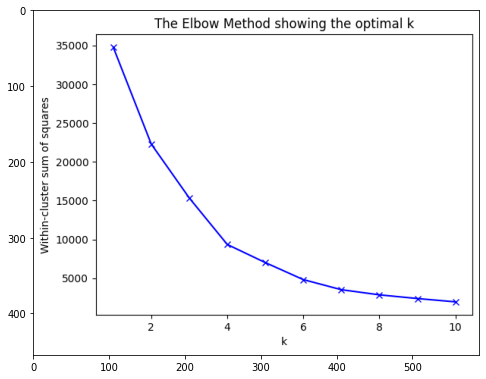

In [114]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores


X = df2[[col for col in df_final.columns if 'section' in col]]
wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# plt.figure(figsize=(8, 8))
# barplot0 = mpimg.imread('../input/BigDataDerby2/elbow.png')
# plt.imshow(barplot0)
# plt.show()

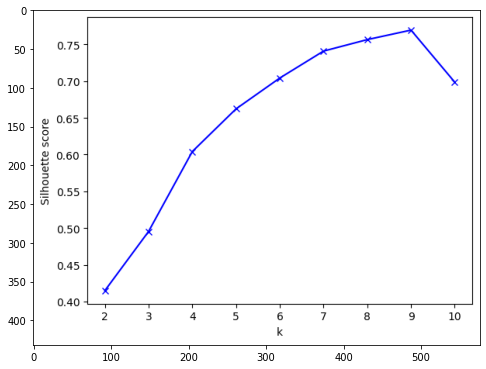

In [115]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores


from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

# plt.figure(figsize=(8, 8))
# barplot0 = mpimg.imread('../input/BigDataDerby2/silhouette.png')
# plt.imshow(barplot0)
# plt.show()

KMeans for k=4

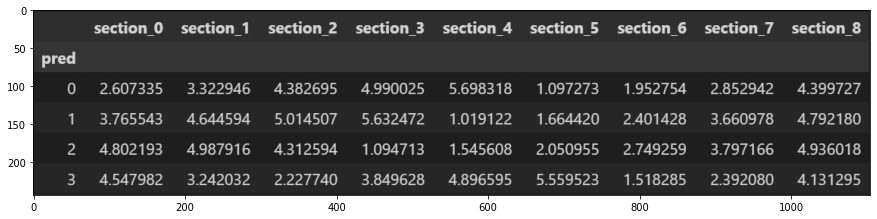

In [116]:
kmeans_4 = KMeans(n_clusters=4, random_state=0)
kmeans_4.fit(X)
y_kmeans_4 = kmeans_4.predict(X)

df_km_4 = X.copy()
df_km_4['pred'] = y_kmeans_4
df_km_4.groupby('pred').mean()

# plt.figure(figsize=(15, 15))
# barplot0 = mpimg.imread('../input/datasets-heads/kmeans4.png')
# plt.imshow(barplot0)
# plt.show()

KMeans for k=8

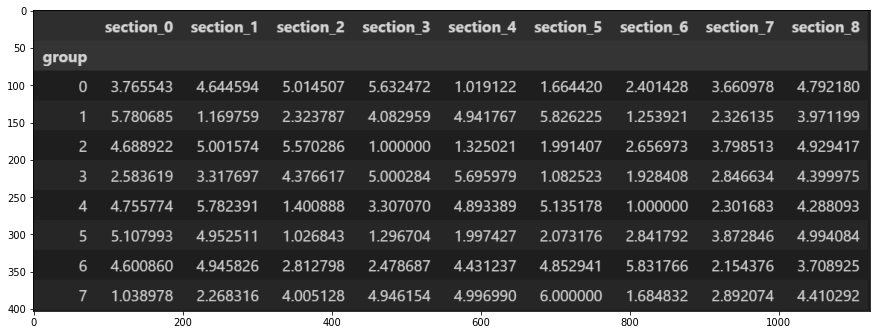

In [117]:
kmeans_8 = KMeans(n_clusters=8, random_state=0)
kmeans_8.fit(X)
y_kmeans_8 = kmeans_8.predict(X)

df_km_8 = X.copy()
df_km_8['group'] = y_kmeans_8
df_km_8.groupby('group').mean()

# plt.figure(figsize=(15, 15))
# barplot0 = mpimg.imread('../input/datasets-heads/kmeans8.png')
# plt.imshow(barplot0)
# plt.show()

Based on graphical analysis, we considered two different numbers of clusters: k=4 and k=8. Analysis of aggregated section means for each bucket proved that the second solution is more accurate.

In [118]:
df2['group'] = y_kmeans_8
df_final = df_final.merge(df2[['track_id', 'race_date', 'race_number', 'group']], on = ['track_id', 'race_date', 'race_number'], how='left')

df_final.drop([col for col in df_final.columns if 'section_' in col], axis=1, inplace=True)

### Scaling the final position to range (0,1)

In [119]:
df_final['position_at_finish_max'] = df_final.groupby(['track_id', 'race_date', 'race_number']).position_at_finish.transform('max')
df_final['position_at_finish_rel'] = df_final.position_at_finish / df_final.position_at_finish_max
df_final.drop('position_at_finish_max', axis=1, inplace=True)

And finally, this is our final data:

In [120]:
big_data_derby_final_data_head = pd.read_csv('../input/datasets-heads/big_data_derby_final_data_head.csv', index_col=0)
big_data_derby_final_data_head

track_id   race_date  race_number  program_number  distance_id  \
0      AQU  2019-01-01            1               1          650   
1      AQU  2019-01-01            1               2          650   
2      AQU  2019-01-01            1               3          650   
3      AQU  2019-01-01            1               4          650   
4      AQU  2019-01-01            1               5          650   

   position_at_finish  avg_rel_speed_mean_0  avg_speed_to_pack_speed_mean_0  \
0                   2              0.634218                        1.037535   
1                   3              0.592577                        0.924068   
2                   4              0.625345                        1.005980   
3                   5              0.610590                        0.950547   
4                   1              0.606139                        0.945177   

   position_in_race_mean_0  angle_mean_0  ...  energy_saved_mean_7  \
0                 1.857143      0.217252  ...             0.000000   
1                 4.594595      0.351611  ...             0.000000   
2                 2.142857      0.498306  ...             0.000000   
3                 2.583333      0.373787  ...             0.000000   
4                 4.162162      0.272478  ...             0.004848   

   avg_rel_speed_mean_8  avg_speed_to_pack_speed_mean_8  \
0              0.784054                        1.013877   
1              0.783590                        1.019404   
2              0.747539                        0.968229   
3              0.740325                        0.959387   
4              0.804245                        1.040077   

   position_in_race_mean_8  angle_mean_8  dst_covered_perc_sum_8  \
0                      1.0      0.109786                0.099862   
1                      5.0      0.150944                0.099803   
2                      3.0      0.082341                0.098495   
3                      4.0      0.083122                0.100796   
4                      2.0      0.122928                0.102434   

   dst_covered_perc_cum_max_8  energy_saved_mean_8  group  \
0                    0.898674                  0.0      0   
1                    0.899670                  0.0      0   
2                    0.897392                  0.0      0   
3                    0.898606                  0.0      0   
4                    0.899612                  0.0      0   

   position_at_finish_rel  
0                     0.4  
1                     0.6  
2                     0.8  
3                     1.0  
4                     0.2  

[5 rows x 71 columns]

### Dividing the table into 8 (similar races)

In [121]:
df_final_0 = df_final[df_final.group == 0]
df_final_1 = df_final[df_final.group == 1]
df_final_2 = df_final[df_final.group == 2]
df_final_3 = df_final[df_final.group == 3]
df_final_4 = df_final[df_final.group == 4]
df_final_5 = df_final[df_final.group == 5]
df_final_6 = df_final[df_final.group == 6]
df_final_7 = df_final[df_final.group == 7]

In [122]:
columns_to_del_2 = ['Unnamed: 0','track_id', 'race_date', 'race_number', 'program_number', 'distance_id', 'position_at_finish', 'group', 'position_at_finish_rel']
columns_to_del_3 = [col for col in df_final.columns if 'position_in_race_mean_' in col]
columns_to_del_4 = [col for col in df_final.columns if '_5' in col or '_6' in col or '_7' in col or '_8' in col]
columns_to_del_5 = [col for col in df_final.columns if 'avg_rel_speed_max_' in col or 'dst_covered_perc_sum' in col or 'angle_max' in col]
columns_to_del_6 = [col for col in df_final.columns if 'avg_rel_speed_mean_' in col or 'dst_covered_perc_sum' in col or 'angle_max' in col]

### Plots showing races in each clusters per `track_id`
The color indicates races' stage - the darker the more advanced the race.

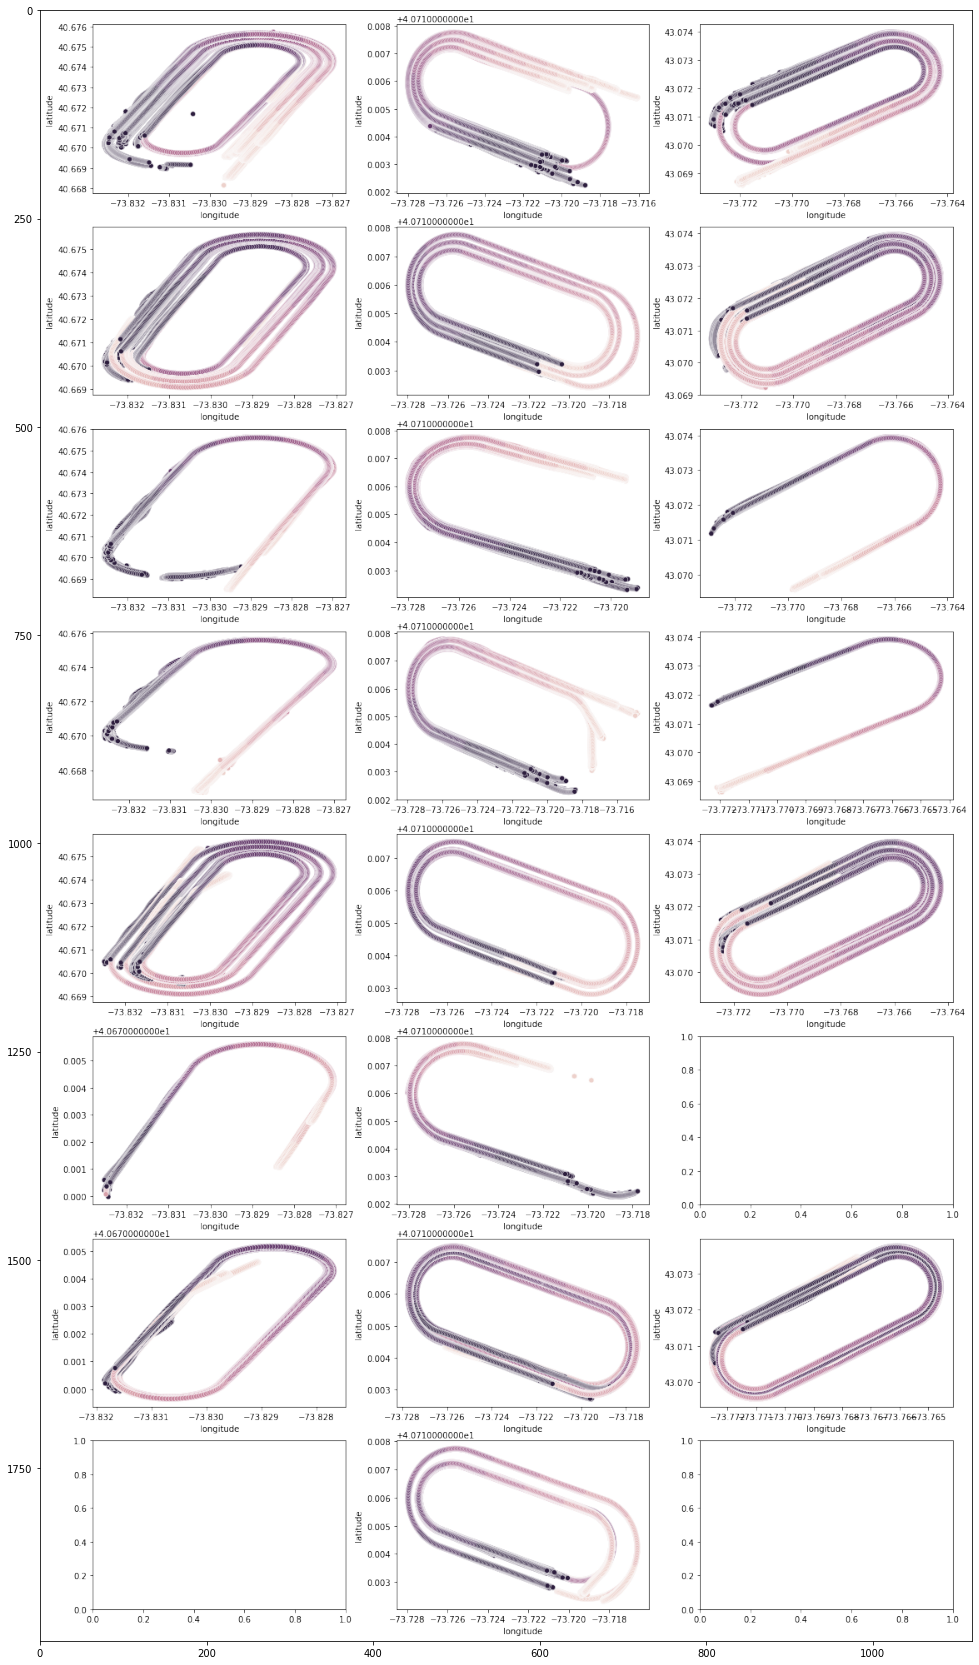

In [123]:
plt.figure(figsize=(30, 30))
barplot0 = mpimg.imread('../input/bigdataderby3/3x8.png')
plt.imshow(barplot0)
plt.show()

#### Cluster 0  
Start at the end of a curve and racing throug straight, curve and straight.

In [141]:
y = df_final_0['position_at_finish_rel']
X = df_final_0.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.35)
model_full_0 = DecisionTreeRegressor()
model_full_0.fit(X_train, y_train)
pred_full_0 = model_full_0.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_0),'\n',
    mean_squared_error(y_train, model_full_0.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_0),'\n',
    max_error(np.array(y_train), model_full_0.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_0),'\n',
    median_absolute_error(np.array(y_train), model_full_0.predict(X_train))
)

0.15214136912358742 2.0423815224199524e-35 0.9230769230769231 1.1102230246251565e-16 0.2777777777777778 0.0


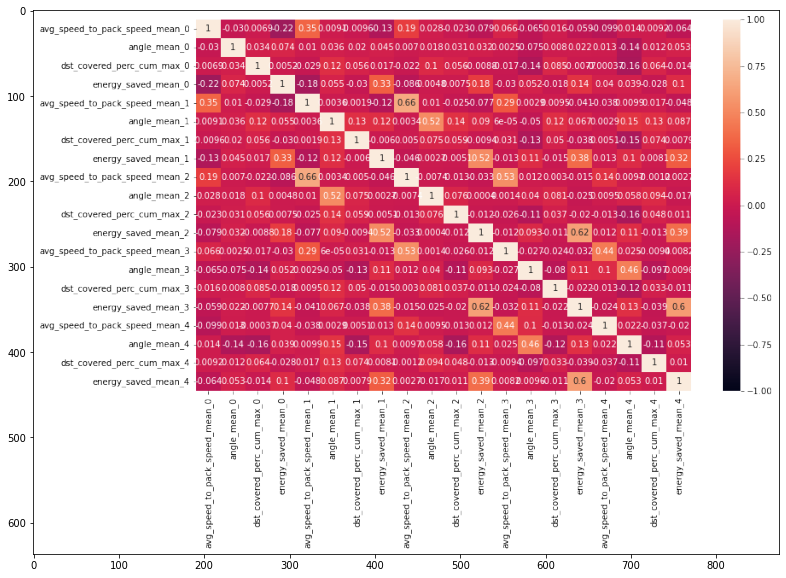

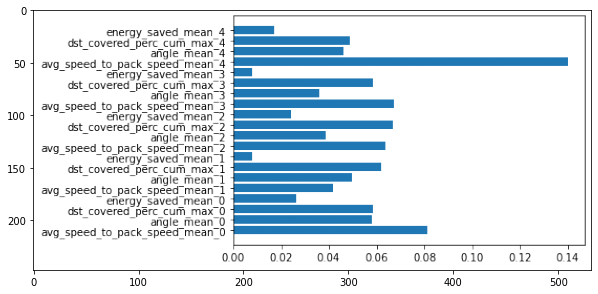

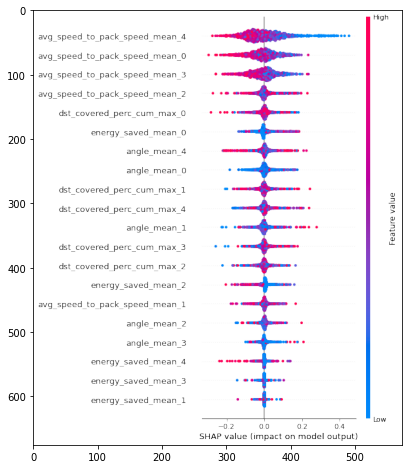

In [125]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap0.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot0.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap0.png')
plt.imshow(barplot0)
plt.show()


#### Cluster 1  
Start at the beginning of a curve and racing for approximately 1 lap.

In [126]:
y = df_final_1['position_at_finish_rel']
X = df_final_1.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_1 = DecisionTreeRegressor()
model_full_1.fit(X_train, y_train)
pred_full_1 = model_full_1.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_1),'\n',
    mean_squared_error(y_train, model_full_1.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_1),'\n',
    max_error(np.array(y_train), model_full_1.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_1),'\n',
    median_absolute_error(np.array(y_train), model_full_1.predict(X_train))
)

0.14515344262286672 1.0246326797725196e-34 0.9166666666666667 1.1102230246251565e-16 0.2714285714285714 0.0


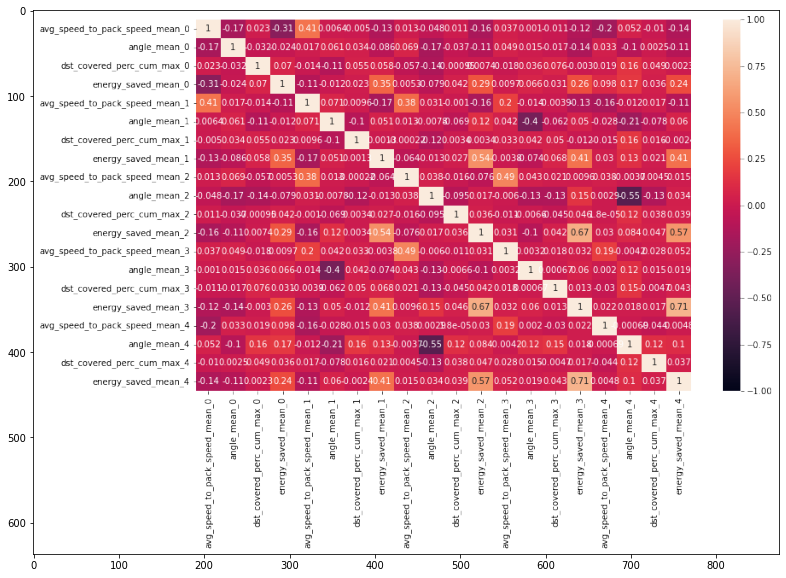

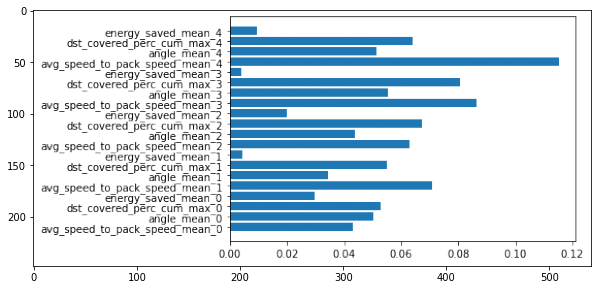

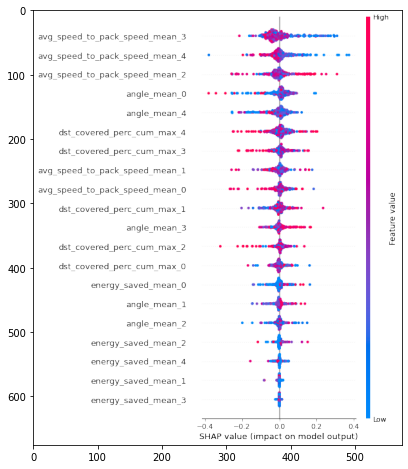

In [127]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap1.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot1.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap1.png')
plt.imshow(barplot0)
plt.show()


#### Cluster 2  
Start at the beginning of a straight and racing throug straight, curve and straight.

In [128]:
y = df_final_2['position_at_finish_rel']
X = df_final_2.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_2 = DecisionTreeRegressor()
model_full_2.fit(X_train, y_train)
pred_full_2 = model_full_2.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_2),'\n',
    mean_squared_error(y_train, model_full_2.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_2),'\n',
    max_error(np.array(y_train), model_full_2.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_2),'\n',
    median_absolute_error(np.array(y_train), model_full_2.predict(X_train))
)

0.14422972227362227 2.2837113965066036e-36 0.9090909090909091 2.7755575615628914e-17 0.254040404040404 0.0


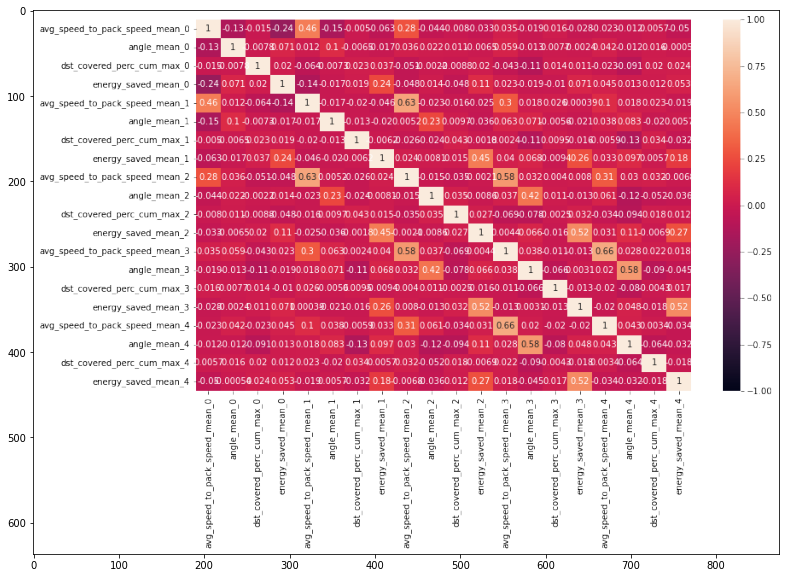

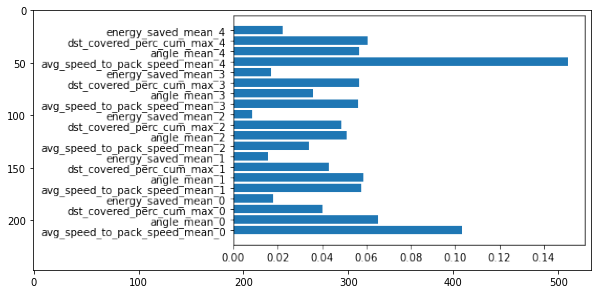

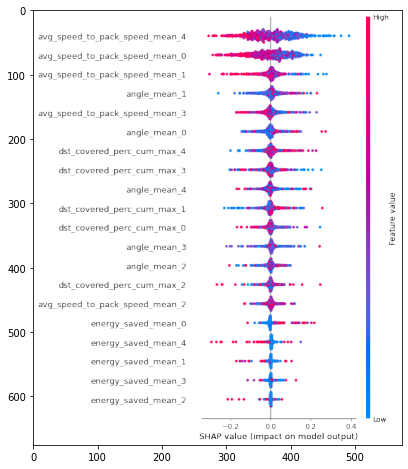

In [129]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap2.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot2.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap2.png')
plt.imshow(barplot0)
plt.show()


#### Cluster 3  
Start in the middle of a curve (or at the beginning of an extended straight) and racing through straight, curve and straight

In [130]:
y = df_final_3['position_at_finish_rel']
X = df_final_3.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_3 = DecisionTreeRegressor()
model_full_3.fit(X_train, y_train)
pred_full_3 = model_full_3.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_3),'\n',
    mean_squared_error(y_train, model_full_3.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_3),'\n',
    max_error(np.array(y_train), model_full_3.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_3),'\n',
    median_absolute_error(np.array(y_train), model_full_3.predict(X_train))
)

0.14337415055496325 4.3997976519052667e-35 0.9166666666666667 1.1102230246251565e-16 0.26666666666666666 0.0


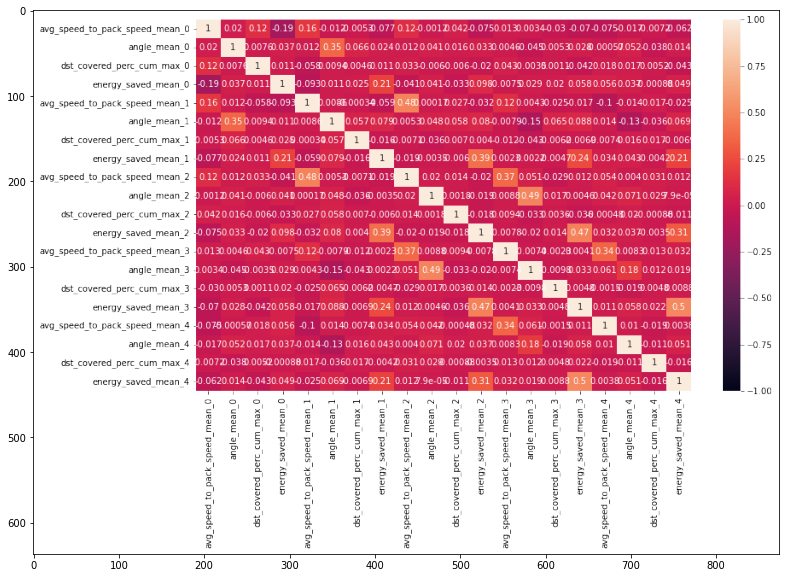

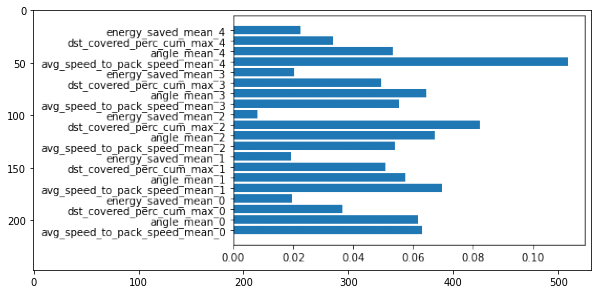

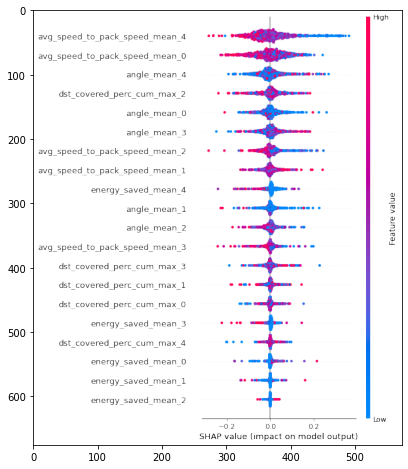

In [131]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap3.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot3.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap3.png')
plt.imshow(barplot0)
plt.show()


#### Cluster 4  
Start at the beginning of a straight and racing for 1 lap + 1 straight.

In [132]:
y = df_final_4['position_at_finish_rel']
X = df_final_4.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_4 = DecisionTreeRegressor()
model_full_4.fit(X_train, y_train)
pred_full_4 = model_full_4.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_4),'\n',
    mean_squared_error(y_train, model_full_4.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_4),'\n',
    max_error(np.array(y_train), model_full_4.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_4),'\n',
    median_absolute_error(np.array(y_train), model_full_4.predict(X_train))
)

0.15672159201239796 1.4231009441284995e-35 0.9166666666666667 5.551115123125783e-17 0.2857142857142857 0.0


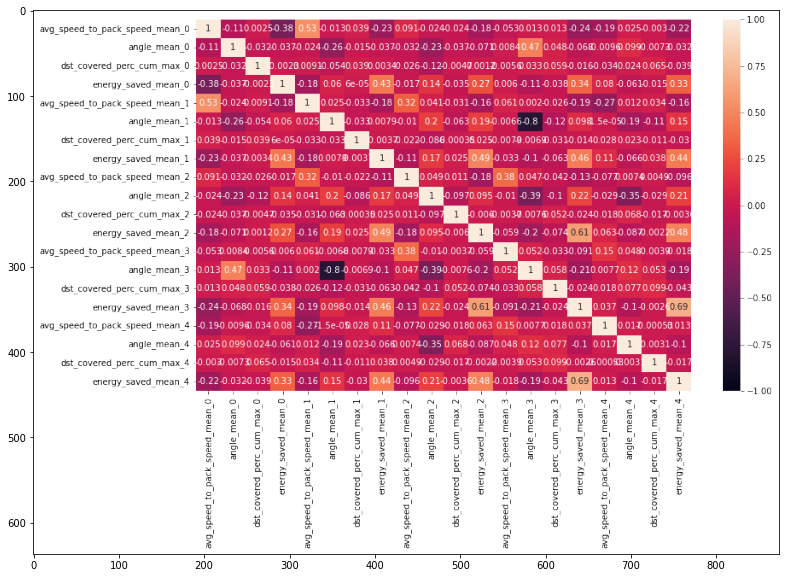

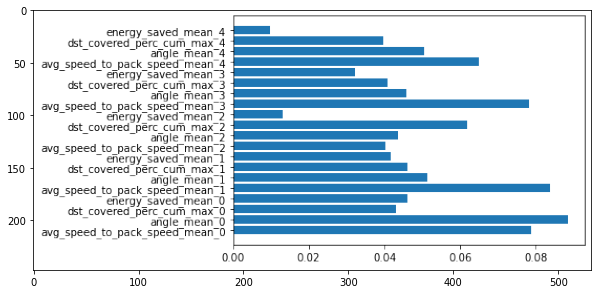

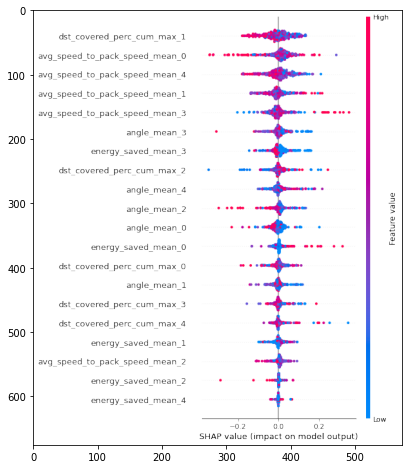

In [133]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap4.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot4.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap4.png')
plt.imshow(barplot0)
plt.show()


#### Cluster 5  
Start in the middle of a satraight and racing through the remainder of this straight, curve and straight.

In [134]:
y = df_final_5['position_at_finish_rel']
X = df_final_5.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_5 = DecisionTreeRegressor()
model_full_5.fit(X_train, y_train)
pred_full_5 = model_full_5.predict(X_test)


print(
    mean_squared_error(y_test, pred_full_5),'\n',
    mean_squared_error(y_train, model_full_5.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_5),'\n',
    max_error(np.array(y_train), model_full_5.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_5),'\n',
    median_absolute_error(np.array(y_train), model_full_5.predict(X_train))
)

0.15122540979673085 0.0 0.8888888888888888 0.0 0.2857142857142857 0.0


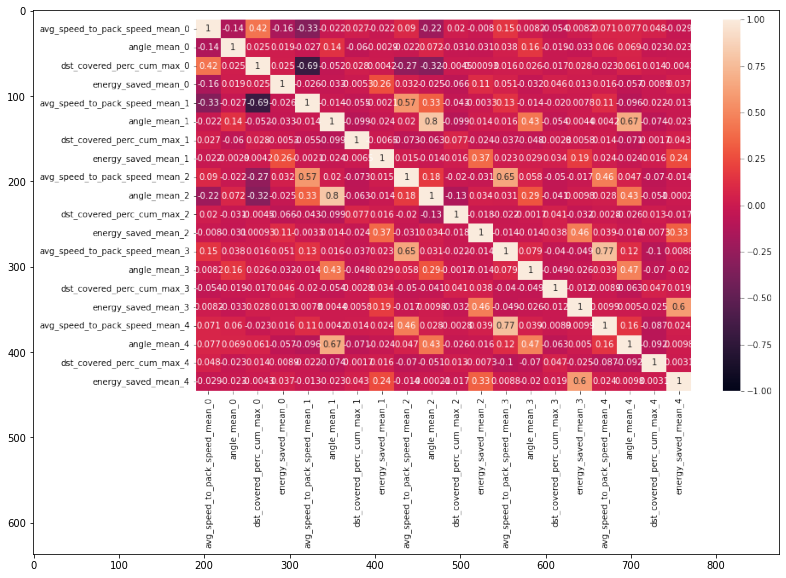

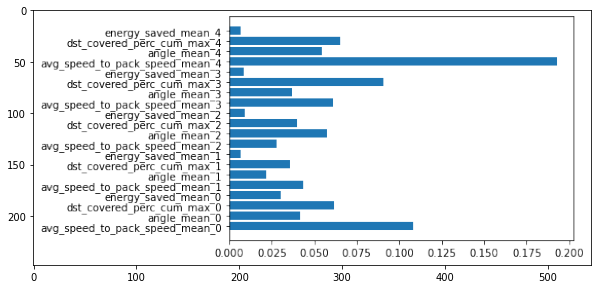

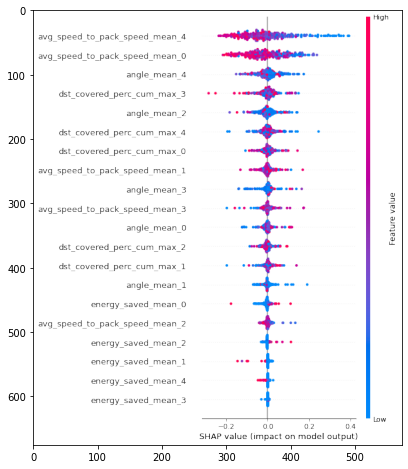

In [135]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap5.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot5.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap5.png')
plt.imshow(barplot0)
plt.show()


#### Clusters 6 and 7  
Low number of observations in these clusters might cause misleading conclusions.

In [136]:
y = df_final_6['position_at_finish_rel']
X = df_final_6.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_6 = DecisionTreeRegressor()
model_full_6.fit(X_train, y_train)
pred_full_6 = model_full_6.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_6),'\n',
    mean_squared_error(y_train, model_full_6.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_6),'\n',
    max_error(np.array(y_train), model_full_6.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_6),'\n',
    median_absolute_error(np.array(y_train), model_full_6.predict(X_train))
)

0.17566383227081409 0.0 0.9 0.0 0.26428571428571435 0.0


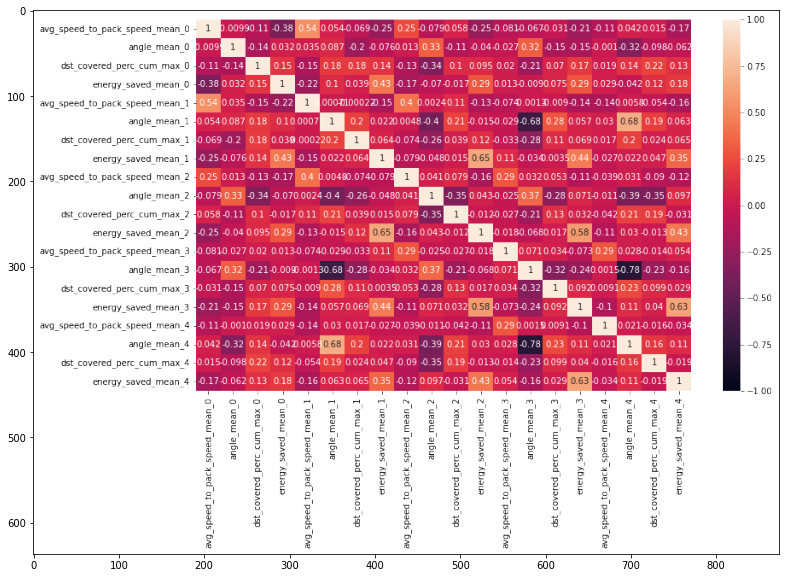

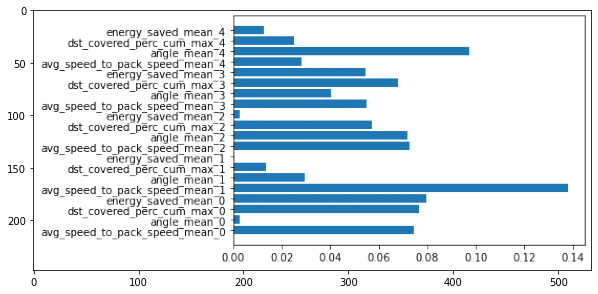

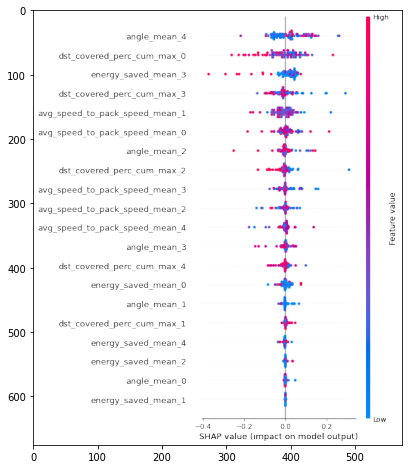

In [137]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap6.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot6.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap6.png')
plt.imshow(barplot0)
plt.show()


In [138]:
y = df_final_7['position_at_finish_rel']
X = df_final_7.drop(columns_to_del_2 + columns_to_del_3 + columns_to_del_4 +  columns_to_del_6, axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.3)
model_full_7 = DecisionTreeRegressor()
model_full_7.fit(X_train, y_train)
pred_full_7 = model_full_7.predict(X_test)

print(
    mean_squared_error(y_test, pred_full_7),'\n',
    mean_squared_error(y_train, model_full_7.predict(X_train)),'\n',
    max_error(np.array(y_test), pred_full_7),'\n',
    max_error(np.array(y_train), model_full_7.predict(X_train)),'\n',
    median_absolute_error(np.array(y_test), pred_full_7),'\n',
    median_absolute_error(np.array(y_train), model_full_7.predict(X_train))
)

0.1575492427670077 1.400676323190717e-34 0.8888888888888888 1.1102230246251565e-16 0.2873015873015873 0.0


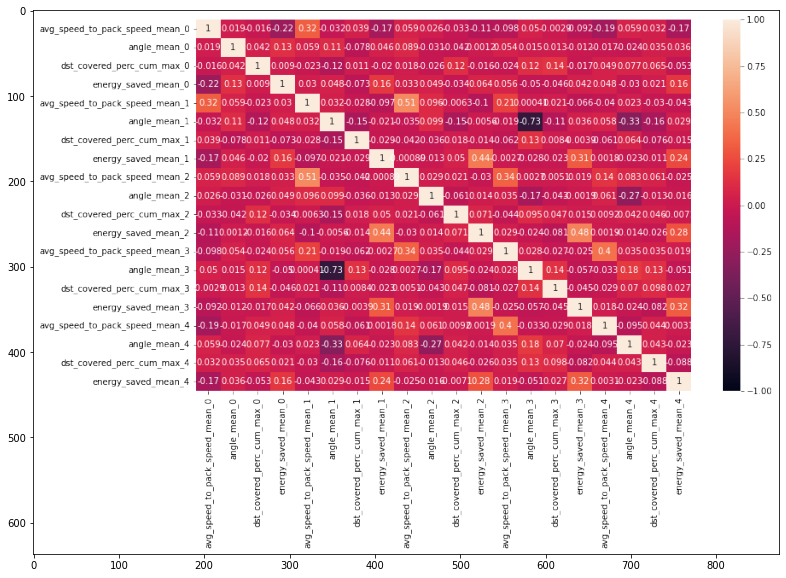

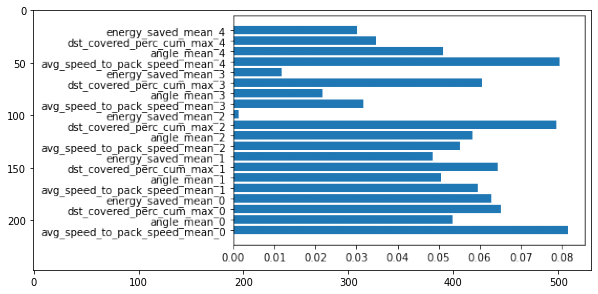

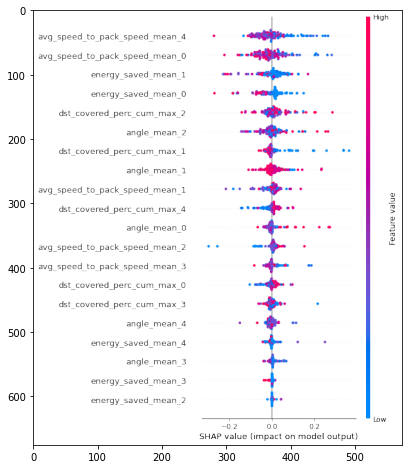

In [139]:
plt.figure(figsize=(15, 10))
barplot0 = mpimg.imread('../input/BigDataDerby/heatmap7.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(10, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/barplot7.png')
plt.imshow(barplot0)
plt.show()

plt.figure(figsize=(8, 8))
barplot0 = mpimg.imread('../input/BigDataDerby/shap7.png')
plt.imshow(barplot0)
plt.show()

Clustering algorithm included dividing the tracks into 6 parts:  
1 - beginning of curve  
2 - middle of curve  
3 - end of curve  
4 - beginning of straight  
5 - middle of straight  
6 - end of straight  
and calculating average position (ranging from 1 to 6) of horses during subsequent deciles of a race.  

This approach allowed us to successfully (excluding several odd races) group races based on their length and placement of the starting line on the track.  

To cluster the processed data, consisting of 9 variables (1 for each decile, excluding the last one due to several anomalies), we used the K-means algorithm.  

We believe that this approach could prove very useful in further analyses of racing data and, especially with more data available, become a more accurate and powerful tool to examine racing strategies based on a particular race's cluster.  

## Explaining the models

Unfortunately, the models did not produce as many insights as possible, but we managed to deduce a few things:

* If a race starts on a curve, then its prefered to straighten out as soon as possible, in order to gain speed faster.

* For races starting with a straight (e.g. cluster (2)) , its helpful to stay behind another horse in the beginning of a race, to make full use of drafting.

* Drafting, being a useful tool in jockey's arsenal, is not always the best strategy. Drafting right before a curve tends to produce greater results, compared to anywhere else on the track.

* In general, unsurprisingly, the most important features tend to be speed features (the fastest horse wins)

